In [119]:
from intanutil.load_intan_rhd_format import read_data

import numpy as np
import matplotlib.pyplot as plt
import glob
import re # Regular expression operations
import pandas as pd
from scipy import signal
import mne
from tqdm import tqdm
import os
from shapely.geometry import Point, Polygon
import geopandas as gpd
from matplotlib.mlab import specgram
from scipy.signal import medfilt 
import seaborn as sb
plt.rcParams["axes.labelsize"]=16
plt.rcParams["font.size"]=14
plt.rcParams["font.family"] = "Arial"

In [128]:
def init_ezm_gem():
    open_area1 = Polygon([(78, 40), (128, 110), (298, 119), (360, 60), (280, 0),(156, 0)])
    open_area2 = Polygon([(280, 291), (338, 369), (260, 400), (106, 400), (49, 335), (113, 277)])
    close_area1 = Polygon([(49, 335), (113, 277), (128, 110), (78, 40), (0,100), (0, 270)])
    close_area2 = Polygon([(360, 60), (298, 119), (280, 291), (338, 369), (400, 280), (400, 160)])
    return [open_area1, open_area2, close_area1, close_area2]
def init_electrod_gem():
    '''
    The logic of the id array is that the indices from 0-63 correspond to the
    electrode pads from top to bottom in their geometrical positions, and
    the corresponding entries show which Intan amplifier channel belongs to
    that electrode pad. (e.g. Ch 51 in Intan software is the deepest
    electrode, Ch 28 in Intan software is the most superficial one).
    '''

    id = {0:[51], 1:[53], 2:[48], 3:[37], 4:[61], 5:[59], 6:[36], 7:[44], 
          8:[63], 9:[58], 10:[55], 11:[50], 12:[47], 13:[42], 14:[39], 15:[34], 
          16:[62], 17:[57], 18:[54], 19:[49], 20:[46], 21:[41], 22:[38], 23:[33], 
          24:[52], 25:[60], 26:[40], 27:[35], 28:[56], 29:[43], 30:[45], 31:[32], 
          32:[3], 33:[4], 34:[5], 35:[16], 36:[13], 37:[0], 38:[24], 39:[19], 
          40:[30], 41:[25], 42:[22], 43:[17], 44:[14], 45:[9], 46:[6], 47:[2],
          48:[31], 49:[26], 50:[23], 51:[18], 52:[15], 53:[10], 54:[8], 55:[1], 
          56:[7], 57:[11], 58:[21], 59:[20], 60:[12], 61:[27], 62:[29], 63:[28]
         }

    vertical_distance = 25 ## um
    horizontal_distance = 5 ## um

    geometry = {}

    for i in range(64):
        geometry[id[63-i][0]] = (i*horizontal_distance, i*vertical_distance)
        
    
    return [geometry]


def load_all_data(dataset):
    
    data     = read_data  (dataset['lfp_dir']
                           +'/'
                           +dataset['lfp_file_list'][0])
    location = pd.read_hdf(dataset['loc_file']) 
    
    ch_name = [d['native_channel_name'] for d in data['amplifier_channels']]
    ch_impedence = np.array([int(d['electrode_impedance_magnitude']) for d in data['amplifier_channels']])/1000
    
    amplifier_data = []
    event_raw      = []
    for file in dataset['lfp_file_list']:
        print('>>'+file)
        data = read_data  (dataset['lfp_dir']+'/'+file)
        amplifier_data.append(data['amplifier_data'])
        event_raw.append(data['board_dig_in_data'])

    amplifier_data = np.concatenate(amplifier_data, axis = 1)
    event_raw      = np.concatenate(event_raw, axis = 1)
    data.update({'amplifier_data'   : amplifier_data,
                 'board_dig_in_data': event_raw})
    
    return {'data_info'    : dataset, 
            'lfp'          : data,
            'loc'          : location,
            'ch_name'      : ch_name,
            'ch_impedence' : ch_impedence,
            'event_raw'    : event_raw,
            'sampling_rate': data['frequency_parameters']['board_adc_sample_rate']} 
def process_get_spike_train(dataset):
    print("Escape Spike Train.")
    return dataset

def process_downsample_by_50(dataset):
    ephys_2000Hz = signal.decimate(dataset['lfp']['amplifier_data'], 10, ftype='fir', axis= -1, zero_phase=True)
    ephys_400hz = signal.decimate(ephys_2000Hz, 5, ftype='fir', axis= -1, zero_phase=True)
    lfp         = dataset['lfp']
    lfp['amplifier_data'] =  ephys_400hz

    dataset.update({'lfp':lfp})
    dataset.update({'sampling_rate':400})
    return dataset

def process_band_pass_filer(dataset):
    freqs = {
    'Raw':0,
    'delta':{'low': 1,      'high':4},
    'theta':{'low': 4,      'high':8},
    'alpha':{'low': 8,      'high':13},
    'beta' :{'low': 13,     'high':30},
    'gamma':{'low': 30,     'high':70}
    }
    sampling_rate = dataset['sampling_rate']
  
    theta = np.zeros(np.shape(dataset['lfp']['amplifier_data']))
    beta  = np.zeros(np.shape(dataset['lfp']['amplifier_data']))
    gamma = np.zeros(np.shape(dataset['lfp']['amplifier_data']))
    
    bands = {'theta':{'value':theta},
             'beta' :{'value':beta},
             'gamma':{'value':gamma}
            }
    
    for i in tqdm(range(dataset['lfp']['amplifier_data'].shape[0])):
        for frq in bands:
            bands[frq]['value'][i, :] = mne.filter.filter_data(dataset['lfp']['amplifier_data'][i, :], 
                                               sfreq  = sampling_rate, 
                                               l_freq = freqs[frq]['low'], 
                                               h_freq = freqs[frq]['high'], 
                                               n_jobs=1)
    dataset['bands'] = bands    
    return dataset
    

def process_hilbert_tranform(dataset):

    for frq in dataset['bands']:
        power = np.zeros(np.shape(dataset['bands'][frq]['value']))
        phase = np.zeros(np.shape(dataset['bands'][frq]['value']))

        for i in range(dataset['lfp']['amplifier_data'].shape[0]):        
            # convert uV to mV
            hilbert_trans = signal.hilbert(dataset['bands'][frq]['value'][i, :]*10e-3) 
            ### square the amplitude to get the power
            power[i, :] = np.abs(hilbert_trans)**2 
            phase[i, :] = np.angle(hilbert_trans)

        dataset['bands'][frq].update({'power':power})
        dataset['bands'][frq].update({'phase':phase})
    return dataset


def plot_location(dataset, with_filter = True, axs = None):
    fig = plt.figure(figsize=(11, 11))
    score = dataset['loc'].columns[0][0];
    x_data = dataset['loc'][score, 'shoulder', 'x'][:]
    y_data = dataset['loc'][score, 'shoulder', 'y'][:]
    if with_filter:
        kernel_size = 5
        x_data = medfilt(x_data, kernel_size)
        y_data = medfilt(y_data, kernel_size)
    sb.scatterplot(x=x_data, y=y_data, s=5, color=".15")
    sb.histplot   (x=x_data, y=y_data, bins=100, pthresh=.1, cmap="mako")
    sb.kdeplot    (x=x_data, y=y_data, levels=5, color="w", linewidths=1)

def plot_hist(dataset, band_frq, axs = None):

    working_ch_hipp = range(30) + 30
    if axs == None:
        fig, axs = plt.subplots(len(working_ch_hipp), 1, figsize=(4, 4*8))

    for i, ele in enumerate(working_ch_hipp):
        phase_diff1 = dataset['bands'][band_frq][0,:] - dataset['bands'][band_frq][ele-30,:]
        axs[i].hist(theta_phase_diff1, bins=round(len(theta_phase_diff1)/srate*0.5), alpha=1) ### bin size = 0.5 second
        axs[i].set_title('Theta phase lag / Ch64 vs. Ch' + str(ele))
        axs[i].grid(True)

    fig.tight_layout()
    plt.show()

def plot_event(dataset, axs = None):
    fig = plt.figure(figsize=(11, 4))
    sampling_rate = dataset['sampling_rate']
    time = np.arange(0, dataset['event_raw'].shape[-1]/sampling_rate, 1/sampling_rate)
    plt.plot(time, dataset['event_raw'][0], '--k', alpha=.4)
    plt.plot(time, dataset['event_raw'][1], '--b', alpha=.2)

    plt.title('Trigger + video_frame')
    plt.xlabel('sec')
    plt.show()    

def plot_spectrum(dataset, channel_list = None, axs = None):
    if channel_list == None: 
        channel_list = [0]
    if axs == None:
        fig, axs = plt.subplots(len(channel_list))

    for i, index in enumerate(channel_list):
        Pxx, frq, t = specgram(ezm_data['lfp']['amplifier_data'][index,:],
                               NFFT=1000,
                               Fs=400,
                               noverlap=900,
                               pad_to=8192)
        axs[i].pcolormesh(t, frq, 10*np.log10(Pxx), cmap='hot', shading='auto')

def plot_compare(dataset1, dataset2, axs = None):
    pass

def process_compare_lfp_vs_loc(dataset):
    return dataset

def plot_compare_lfp_power_vs_loc(dataset, grouby_brain_area, axs = None):
    pass

def stat_compare_lfp_power_vs_loc(dataset, grouby_brain_area, axs = None):
    pass

def plot_compare_lfp_power_coh_vs_loc(dataset, brain_area_1, brain_area_2, axs = None):
    pass

def stat_compare_lfp_power_coh_vs_loc(dataset, brain_area_1, brain_area_2, axs = None):
    pass

def plot_compare_lfp_phase_coh_vs_loc(dataset, brain_area_1, brain_area_2, axs = None):
    pass

def stat_compare_lfp_phase_coh_vs_loc(dataset, brain_area_1, brain_area_2, axs = None):
    pass

def plot_compare_fire_rate_vs_loc(dataset, grouby_brain_area, axs = None):
    pass

def stat_compare_fire_rate_vs_loc(dataset, grouby_brain_area, axs = None):
    pass

In [68]:
# initizaltion
print('Initizaltion..')
[open_area1, open_area2, close_area1, close_area2] = init_ezm_gem()
[geometry] = init_electrod_gem()

#define the location
mPFC_labels = [
 'A-000', 'A-001', 'A-002', 'A-003', 'A-005', 'A-006', 'A-007', 'A-008', 'A-009', 'A-010', 'A-011',
 'A-012', 'A-013', 'A-014', 'A-015', 'A-016', 'A-017', 'A-018', 'A-019', 'A-020', 'A-021', 'A-022', 
 'A-023', 'A-024', 'A-025', 'A-026', 'A-027', 'A-028', 'A-029', 'A-030', 'A-031']

hipp_labels = ['A-036', 'A-044', 'A-050', 'A-055', 'A-058', 'A-059', 'A-061', 'A-063']

arena_data = {'lfp_dir'           : 'raw_data/mBWfus004_Arena/',
              'lfp_file_list'     : ['mBWfus004_arena_201224_145913.rhd',
                                     'mBWfus004_arena_201224_150013.rhd',
                                     'mBWfus004_arena_201224_150113.rhd'],
              'loc_file'          :  'Trajectory/mBWfus004_arena.h5',
              'brain_area'        : {'mPFC':mPFC_labels, 
                                     'hipp':hipp_labels},
              'electrod_geometry' : geometry,
              'timing'            : {'video': 2.0, 
                                     'lfp'  :18.31}
             }

ezm_data   = {'lfp_dir'         : 'raw_data/mBWfus004_EZM/',
              'lfp_file_list'     : ['mBWfus004_EZM_201224_182852.rhd',
                                     'mBWfus004_EZM_201224_182952.rhd',
                                     'mBWfus004_EZM_201224_183052.rhd'],
              'loc_file'          :  'Trajectory/mBWfus004_ezm.h5',
              'brain_area'        :{'mPFC':mPFC_labels, 
                                    'hipp':hipp_labels},
              'electrod_geometry' : geometry,
              'ezm_gem'           : [open_area1, open_area2, close_area1, close_area2],
              'timing'            : {'video': 6.0, 
                                     'lfp':15.36}
             }

#load raw data
print('Load raw data..')
arena_data = load_all_data(arena_data)
ezm_data   = load_all_data(ezm_data)



Initizaltion..
Load raw data..

Reading Intan Technologies RHD2000 Data File, Version 1.5

Found 39 amplifier channels.
Found 0 auxiliary input channels.
Found 0 board ADC channels.
Found 2 board digital input channels.
Found 0 supply voltage channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 60.012 seconds of data.  Amplifiers were sampled at 20.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.7 seconds
>>mBWfus004_arena_201224_145913.rhd

Reading Intan Technologies RHD2000 Data File, Version 1.5

Found 39 amplifier channels.
Found 0 auxiliary input channels.
Found 0 board ADC channels.
Found 2 board digital input channels.
Found 0 supply voltage channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File conta

In [69]:
#Process Spike Detection
print('Process Spike Detection..')
ezm_data   = process_get_spike_train(ezm_data)
arena_data = process_get_spike_train(arena_data)

#Process EMZ Data
print('Process Datasets..')
ezm_data = process_downsample_by_50(ezm_data)
ezm_data = process_band_pass_filer(ezm_data)
ezm_dat  = process_hilbert_tranform(ezm_data)

#Process ARENA Data
arena_data = process_downsample_by_50(arena_data)
arena_data = process_band_pass_filer(arena_data)
arena_data = process_hilbert_tranform(arena_data)

#align loc and lfp
print('Align Timings...')
ezm_data = process_compare_lfp_vs_loc(ezm_data)




Process Spike Detection..
Escape Spike Train.
Escape Spike Train.
Process Datasets..


  0%|          | 0/39 [00:00<?, ?it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

  5%|▌         | 2/39 [00:00<00:02, 14.26it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 10%|█         | 4/39 [00:00<00:02, 15.29it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 15%|█▌        | 6/39 [00:00<00:02, 11.16it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 21%|██        | 8/39 [00:00<00:02, 13.11it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 26%|██▌       | 10/39 [00:00<00:02, 14.26it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 31%|███       | 12/39 [00:00<00:01, 15.03it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 36%|███▌      | 14/39 [00:00<00:01, 15.70it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 41%|████      | 16/39 [00:01<00:01, 16.15it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 46%|████▌     | 18/39 [00:01<00:01, 16.36it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 51%|█████▏    | 20/39 [00:01<00:01, 16.57it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 56%|█████▋    | 22/39 [00:01<00:01, 16.62it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 62%|██████▏   | 24/39 [00:01<00:00, 16.71it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 67%|██████▋   | 26/39 [00:01<00:00, 16.83it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 72%|███████▏  | 28/39 [00:01<00:00, 16.87it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 77%|███████▋  | 30/39 [00:01<00:00, 16.90it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 82%|████████▏ | 32/39 [00:02<00:00, 16.80it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 87%|████████▋ | 34/39 [00:02<00:00, 16.84it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 92%|█████████▏| 36/39 [00:02<00:00, 16.76it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 97%|█████████▋| 38/39 [00:02<00:00, 16.71it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

  0%|          | 0/39 [00:00<?, ?it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

  5%|▌         | 2/39 [00:00<00:02, 17.18it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 10%|█         | 4/39 [00:00<00:02, 17.25it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 15%|█▌        | 6/39 [00:00<00:01, 16.54it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 21%|██        | 8/39 [00:00<00:01, 15.63it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 26%|██▌       | 10/39 [00:00<00:01, 15.27it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 31%|███       | 12/39 [00:00<00:01, 15.04it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 36%|███▌      | 14/39 [00:00<00:01, 14.18it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 41%|████      | 16/39 [00:01<00:01, 14.39it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 46%|████▌     | 18/39 [00:01<00:01, 14.55it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 51%|█████▏    | 20/39 [00:01<00:01, 15.33it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 56%|█████▋    | 22/39 [00:01<00:01, 14.97it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 62%|██████▏   | 24/39 [00:01<00:01, 14.97it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 67%|██████▋   | 26/39 [00:01<00:00, 15.47it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 72%|███████▏  | 28/39 [00:01<00:00, 15.84it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 77%|███████▋  | 30/39 [00:01<00:00, 15.98it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 82%|████████▏ | 32/39 [00:02<00:00, 16.01it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 87%|████████▋ | 34/39 [00:02<00:00, 16.15it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 92%|█████████▏| 36/39 [00:02<00:00, 16.46it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

 97%|█████████▋| 38/39 [00:02<00:00, 16.51it/s]

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 sec)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fi

100%|██████████| 39/39 [00:02<00:00, 15.66it/s]


Align Timings...


In [71]:
#compare the power when
plot_compare(arena_data, ezm_data)


# Compare power vs location (hue: frq band)
plot_compare_lfp_power_vs_loc(ezm_data, grouby_brain_area = ['mPFC','hipp'])
stat_compare_lfp_power_vs_loc(ezm_data, grouby_brain_area = ['mPFC','hipp'])

# Compare power coh (hue: frq band)
plot_compare_lfp_power_coh_vs_loc(ezm_data, 
                            brain_area_1 = 'mPFC', 
                            brain_area_2 = 'hipp')

stat_compare_lfp_power_coh_vs_loc(ezm_data, 
                              brain_area_1 = 'mPFC', 
                              brain_area_2 = 'hipp')

# Compare phase coh (hue: frq band)
plot_compare_lfp_phase_coh_vs_loc(ezm_data, 
                            brain_area_1 = 'mPFC', 
                            brain_area_2 = 'hipp')

stat_compare_lfp_phase_coh_vs_loc(ezm_data, 
                              brain_area_1 = 'mPFC', 
                              brain_area_2 = 'hipp')

# Compare spike vs Loc
plot_compare_fire_rate_vs_loc(ezm_data, grouby_brain_area = ['mPFC','hipp'])


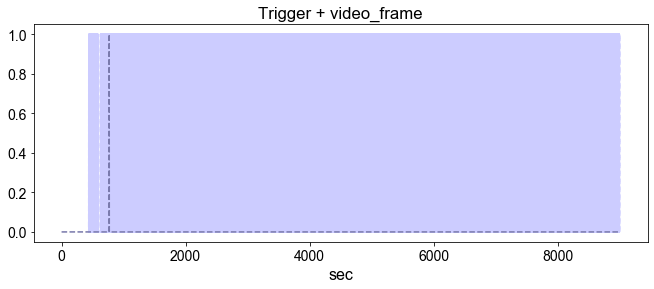

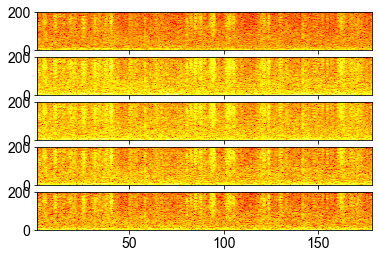

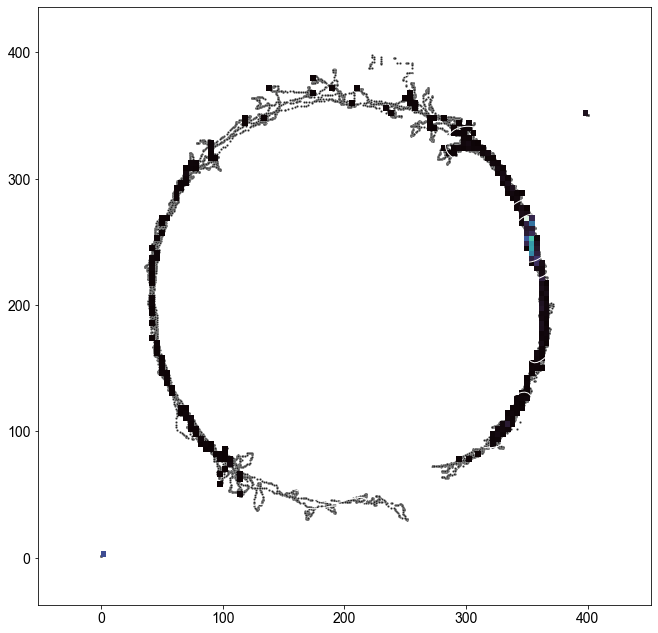

In [129]:
plot_event   (ezm_data)
plot_spectrum(ezm_data, channel_list = [0,1,2,3,4])
plot_location(ezm_data)